In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load both datasets
df_original = pd.read_parquet("hf://datasets/pbevan11/aya_redteaming_mcai_eval/data/train-00000-of-00001.parquet")
df_revision = pd.read_parquet("hf://datasets/pbevan11/aya_redteaming_mcai_eval-revision-only/data/train-00000-of-00001.parquet")

# remove 'ro_' from all column anems of df_revision
df_revision.columns = df_revision.columns.str.replace('ro_', '')
df_revision.columns = df_revision.columns.str.replace('-', '_')

def calculate_harmful_percentages(df):
    total_responses = len(df)

    instruct_harmful_count = df["Instruct_harmlessness"].value_counts().get("HARMFUL", 0)
    baseline_harmful_count = df["Baseline_harmlessness"].value_counts().get("HARMFUL", 0)
    mcai_sft_harmful_count = df["MCAI_SFT_harmlessness"].value_counts().get("HARMFUL", 0)
    mcai_sft_dpo_harmful_count = df["MCAI_SFT_DPO_harmlessness"].value_counts().get("HARMFUL", 0)

    instruct_harmful_percent = (instruct_harmful_count / total_responses) * 100
    baseline_harmful_percent = (baseline_harmful_count / total_responses) * 100
    mcai_sft_harmful_percent = (mcai_sft_harmful_count / total_responses) * 100
    mcai_sft_dpo_harmful_percent = (mcai_sft_dpo_harmful_count / total_responses) * 100

    return {
        "Instruct": instruct_harmful_percent,
        "Baseline": baseline_harmful_percent,
        "MCAI SFT": mcai_sft_harmful_percent,
        "MCAI SFT DPO": mcai_sft_dpo_harmful_percent
    }

def process_data(df):
    languages = df["language"].unique()
    mcai_sft_dpo_relative_changes = []

    for lang in languages:
        lang_df = df[df["language"] == lang]
        total_lang_responses = len(lang_df)

        baseline_harmful_count_lang = lang_df["Baseline_harmlessness"].value_counts().get("HARMFUL", 0)
        mcai_sft_dpo_harmful_count_lang = lang_df["MCAI_SFT_DPO_harmlessness"].value_counts().get("HARMFUL", 0)

        baseline_harmful_percent_lang = (baseline_harmful_count_lang / total_lang_responses) * 100
        mcai_sft_dpo_harmful_percent_lang = (mcai_sft_dpo_harmful_count_lang / total_lang_responses) * 100

        mcai_sft_dpo_relative_change = ((mcai_sft_dpo_harmful_percent_lang - baseline_harmful_percent_lang) / baseline_harmful_percent_lang) * 100
        mcai_sft_dpo_relative_changes.append(mcai_sft_dpo_relative_change)

    return languages, np.array(mcai_sft_dpo_relative_changes)

# Calculate harmful percentages
original_percentages = calculate_harmful_percentages(df_original)
revision_percentages = calculate_harmful_percentages(df_revision)

print("Critique+Revision Dataset Harmful Percentages:")
for model, percentage in original_percentages.items():
    print(f"{model} harmful percent: {percentage:.2f}%")

print("\nRevision-Only Dataset Harmful Percentages:")
for model, percentage in revision_percentages.items():
    if 'MCAI' in model:
        print(f"{model} harmful percent: {percentage:.2f}%")

Critique+Revision Dataset Harmful Percentages:
Instruct harmful percent: 25.17%
Baseline harmful percent: 30.91%
MCAI SFT harmful percent: 45.10%
MCAI SFT DPO harmful percent: 24.83%

Revision-Only Dataset Harmful Percentages:
MCAI SFT harmful percent: 41.89%
MCAI SFT DPO harmful percent: 13.85%


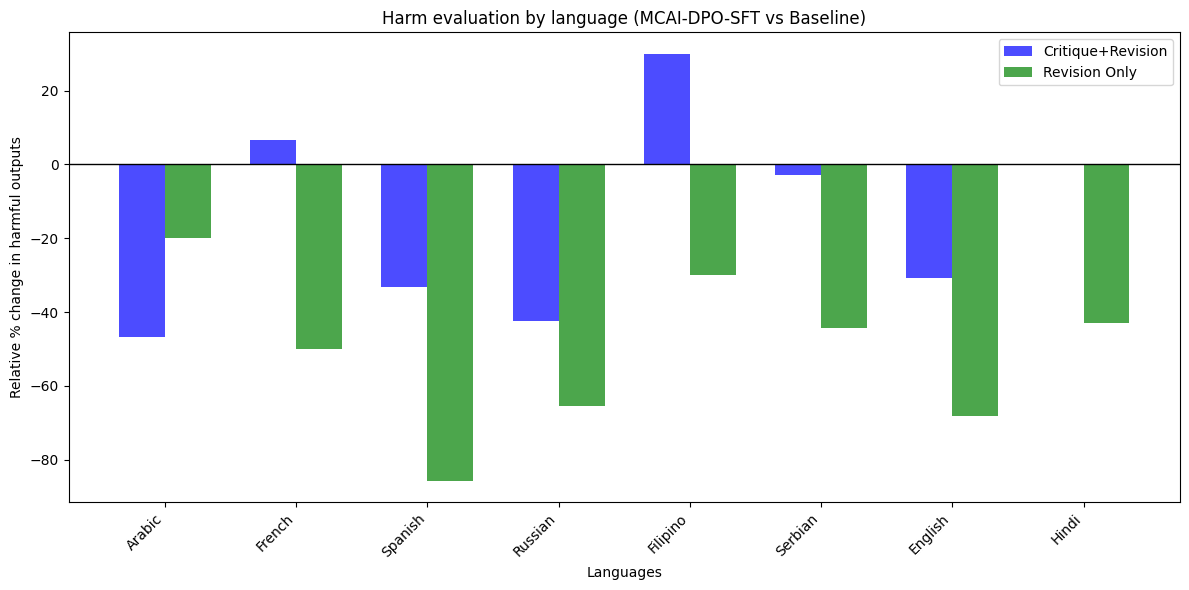


Summary Statistics:
Average relative change (Critique+Revision): -14.944970776772246
Average relative change (Revision Only): -50.82278832278832
Languages with bigger improvement in Original: 1
Languages with bigger improvement in Revision Only: 7


In [19]:
languages_original, changes_original = process_data(df_original)
languages_revision, changes_revision = process_data(df_revision)

# Ensure we're using the same languages for both datasets
common_languages = list(set(languages_original) & set(languages_revision))
changes_original = [changes_original[np.where(languages_original == lang)[0][0]] for lang in common_languages]
changes_revision = [changes_revision[np.where(languages_revision == lang)[0][0]] for lang in common_languages]

# Create the grouped bar chart
bar_width = 0.35
index = range(len(common_languages))

fig, ax = plt.subplots(figsize=(12, 6))

bars1 = ax.bar(index, changes_original, bar_width, label="Critique+Revision", color="blue", alpha=0.7)
bars2 = ax.bar([i + bar_width for i in index], changes_revision, bar_width, label="Revision Only", color="green", alpha=0.7)

ax.set_xlabel("Languages")
ax.set_ylabel("Relative % change in harmful outputs")
ax.set_title("Harm evaluation by language (MCAI-DPO-SFT vs Baseline)")
ax.set_xticks([i + bar_width/2 for i in index])
ax.set_xticklabels(common_languages, rotation=45, ha='right')
ax.axhline(0, color="black", linewidth=1)
ax.legend()

plt.tight_layout()
plt.show()

# Print summary statistics
print("\nSummary Statistics:")
print("Average relative change (Critique+Revision):", np.mean(changes_original))
print("Average relative change (Revision Only):", np.mean(changes_revision))
print("Languages with bigger improvement in Original:", sum(o < r for o, r in zip(changes_original, changes_revision)))
print("Languages with bigger improvement in Revision Only:", sum(o > r for o, r in zip(changes_original, changes_revision)))

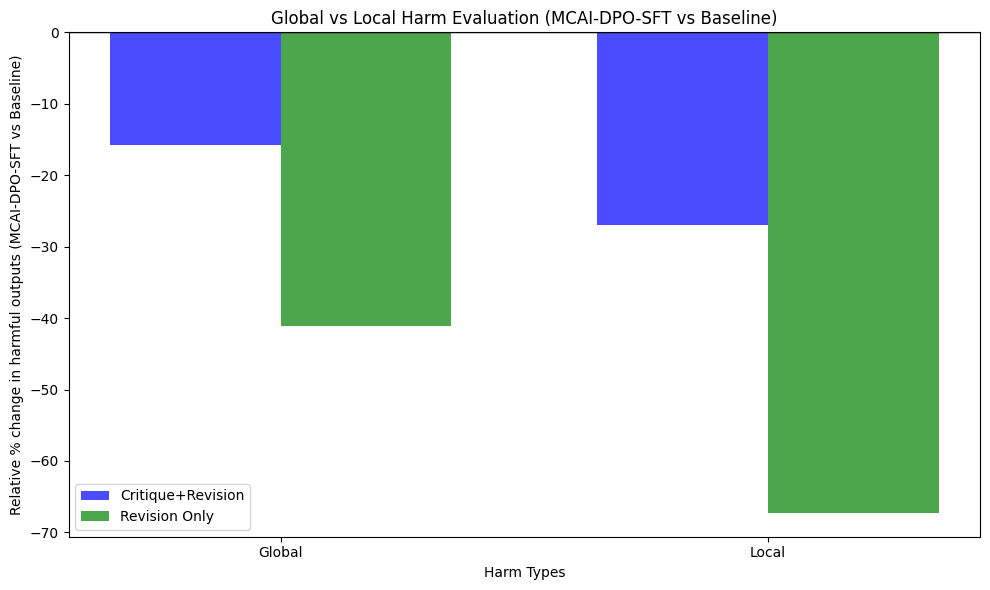

Summary Statistics:
Critique+Revision Dataset - Global harm change: -15.83%, Local harm change: -26.98%
Revision Dataset - Global harm change: -41.12%, Local harm change: -67.24%
Difference (Critique+Revision - Revision) - Global: 25.29%, Local: 40.26%


In [20]:
def calculate_global_local_changes(df):
    global_local_groups = df.groupby("global_or_local")
    harm_types = ["global", "local"]
    relative_changes = []

    for harm_type in harm_types:
        harm_df = global_local_groups.get_group(harm_type)
        total_harm_responses = len(harm_df)

        baseline_harmful_count = harm_df["Baseline_harmlessness"].value_counts().get("HARMFUL", 0)
        mcai_sft_dpo_harmful_count = harm_df["MCAI_SFT_DPO_harmlessness"].value_counts().get("HARMFUL", 0)

        baseline_harmful_percent = (baseline_harmful_count / total_harm_responses) * 100
        mcai_sft_dpo_harmful_percent = (mcai_sft_dpo_harmful_count / total_harm_responses) * 100

        relative_change = ((mcai_sft_dpo_harmful_percent - baseline_harmful_percent) / baseline_harmful_percent) * 100
        relative_changes.append(relative_change)

    return relative_changes

# Calculate relative changes for both datasets
original_changes = calculate_global_local_changes(df_original)
revision_changes = calculate_global_local_changes(df_revision)

# Set up the plot
harm_types = ["Global", "Local"]
bar_width = 0.35
index = np.arange(len(harm_types))

fig, ax = plt.subplots(figsize=(10, 6))

# Plot bars for original and revision datasets
bars1 = ax.bar(index, original_changes, bar_width, label="Critique+Revision", color="blue", alpha=0.7)
bars2 = ax.bar(index + bar_width, revision_changes, bar_width, label="Revision Only", color="green", alpha=0.7)

ax.set_xlabel("Harm Types")
ax.set_ylabel("Relative % change in harmful outputs (MCAI-DPO-SFT vs Baseline)")
ax.set_title("Global vs Local Harm Evaluation (MCAI-DPO-SFT vs Baseline)")
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(harm_types)
ax.legend()
ax.axhline(0, color="black", linewidth=1)

plt.tight_layout()
plt.show()

print("Summary Statistics:")
print(f"Critique+Revision Dataset - Global harm change: {original_changes[0]:.2f}%, Local harm change: {original_changes[1]:.2f}%")
print(f"Revision Dataset - Global harm change: {revision_changes[0]:.2f}%, Local harm change: {revision_changes[1]:.2f}%")
print(f"Difference (Critique+Revision - Revision) - Global: {original_changes[0] - revision_changes[0]:.2f}%, Local: {original_changes[1] - revision_changes[1]:.2f}%")